# "FAVAR - BBE(2005) Replication in R"
> "Replication of Bernanke, Boivin and Eliasz (QJE, 2005) in R. This code is written to facilitate the undertanding of FAVAR rather than to be efficient"

- toc:true
- branch: master
- badges: true
- comments: false
- author: João B. Duarte
- categories: [Time Series, R, FAVAR]

The FAVAR model is represented by the following system:

$$
\begin{align}
X_t &= \Lambda^f F_t + \Lambda^y Y_t + e_t \\ \\
\begin{bmatrix} F_t \\ Y_t \end{bmatrix} &= \Psi(L)\begin{bmatrix} F_{t-1} \\ Y_{t-1} \end{bmatrix} + v_t 
\end{align}
$$

where $F_t$ is the collection of variables that is unobservable, while $Y_t$ is is of the observable. For further description of the FAVAR model and its properties please see BBE (QJE, 2005)

In [ ]:
library(readxl)
library(boot)
library(tsDyn)
library(vars)
library(repr)

In [4]:
# Get original large dataset of BBE (2005): 120 series
data = read_excel("./Data/bbe_data.xlsx")

In [5]:
head(data)

Date,IPP,IPF,IPC,IPCD,IPCN,IPE,IPI,IPM,IPMD,⋯,PU85,PUC,PUCD,PUS,PUXF,PUXHS,PUXM,LEHCC,LEHM,HHSNTN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1959:01,0.013396992,0.008609752,0.007316259,0.005227654,0.009517142,0.013284200,0.018846549,0.031175802,0.045049989,⋯,0.004728141,0.000000000,0.000000000,0.004357305,0.000000000,0.000000000,0.000000000,0.003478264,0.004618946,95.8
1959:02,0.006022800,0.004916504,0.000000000,0.019405634,-0.004747249,0.010731414,0.013885375,0.025638933,0.038650015,⋯,0.004705891,-0.003007521,0.005235614,0.000000000,0.000000000,0.000000000,0.000000000,-0.003478264,0.009174376,96.4
1959:03,0.014342738,0.014547535,0.015653159,0.006396823,0.016505699,0.025817364,0.015959619,0.027254131,0.029650367,⋯,0.000000000,0.000000000,0.000000000,0.004338402,0.003454235,0.000000000,0.000000000,0.006944472,0.004555816,96.9
1959:04,0.008286750,0.009562755,0.004755444,0.020121006,0.000000000,0.031893735,0.005638694,0.025433102,0.034050126,⋯,0.004683849,0.003007521,0.002607563,0.004319661,0.003442344,0.000000000,0.000000000,0.006896579,0.000000000,97.5
1959:05,0.007036611,0.007141339,-0.004755444,0.007458365,-0.007033631,0.023250403,0.003368017,-0.006587149,-0.007362857,⋯,0.004662013,0.000000000,0.000000000,0.000000000,0.003430535,0.003252035,0.003372685,0.003430535,0.004535155,97.2
1959:06,0.001153906,0.008234277,0.013062217,0.019610667,0.008209100,0.002193842,-0.013540671,-0.061158362,-0.105490860,⋯,0.000000000,0.000000000,0.002600782,0.004301082,0.000000000,0.003241494,0.003361348,0.003418807,0.000000000,96.9


In [6]:
# Standardizing data = all variables with mean 0 and standard deviation 1. 
# This step is crucial in PC analysis
data_s = scale(data[,2:121], center = TRUE, scale = TRUE)

## Step 1: Extract principal componentes of all X (including Y)

In [7]:
pc_all = prcomp(data_s, center=FALSE, scale.=FALSE, rank. = 3) 
# summary(pc_all)
C = pc_all$x # saving the principal components

## Step 2: Extract principal componentes of Slow Variables

In [8]:
# Slow Variables
slow_vars = c("IP", "LHUR", "PUNEW", "IPP", "IPF", "IPC", "IPCD", "IPCN", "IPE", "IPI", "IPM",
             "IPMD", "IPMND", "IPMFG", "IPD", "IPN", "IPMIN", "IPUT", "IPXMCA", "PMI", "PMP",
             "GMPYQ", "GMYXPQ", "LHEL", "LHELX", "LHEM", "LHNAG", "LHU680", "LHU5", "LHU14",
             "LHU15", "LHU26", "LPNAG", "LP", "LPGD", "LPMI", "LPCC", "LPEM", "LPED", "LPEN",
             "LPSP", "LPTU", "LPT", "LPFR", "LPS", "LPGOV", "LPHRM", "LPMOSA", "PMEMP", "GMCQ",
             "GMCDQ", "GMCNQ", "GMCSQ", "GMCANQ", "PWFSA", "PWFCSA", "PWIMSA", "PWCMSA", "PSM99Q",
             "PU83", "PU84", "PU85", "PUC", "PUCD", "PUS", "PUXF", "PUXHS", "PUXM", "LEHCC", "LEHM")

In [9]:
data_slow = data_s[, slow_vars]
pc_slow = prcomp(data_slow, center=FALSE, scale.=FALSE, rank. = 3)
F_slow = pc_slow$x

## Step 3: Clean the PC from the effect of observed Y

In [10]:
# Next clean the PC of all space from the observed Y
reg = lm(C ~ F_slow + data_s[,"FYFF"])
#summary(reg)
F_hat = C - data.matrix(data_s[,"FYFF"])%*%reg$coefficients[5,] # cleaning and saving F_hat

## Step 4: Estimate FAVAR and get IRFs

> Warning: The IRFs in BBE are reported in standard deviation units, which means they are reported in the scaled data. No need to scale the data back to original units if want to compare with their paper.


In [11]:
data_var = data.frame(F_hat, "FYFF" = data_s[,"FYFF"])
var = VAR(data_var, p = 13)
#summary(var)

irf_point = irf(var, n.ahead = 48, impulse = "FYFF", response = "FYFF", boot = FALSE)

# Shock size of 25 basis points
impulse_sd = 0.25/sd(data$FYFF)
scale = impulse_sd/(irf_point$irf$FYFF[1]) # position of FYFF response at step 0


# Computing Loading Factors
reg_loadings = lm(data_s ~ F_hat + data_s[,"FYFF"])
loadings = reg_loadings$coefficients
# head(reg_loadings$coefficients)
#summary(reg_loadings)


#### BOOTSTRAPING ########

R = 500 # Number of simulations
nvars = 120 # Number of variables
nsteps = 49 # numbers of steps

IRFs = array(c(0,0,0), dim = c(nsteps,nvars,R))

var = lineVar(data_var, lag = 13, include = "const")
for(j in 1:R){    
    data_boot = VAR.boot(var, boot.scheme ="resample")
    var_boot = VAR(data_boot, lag = 13)
    irf1 = irf(var_boot, n.ahead = 48, impulse = "FYFF", boot = FALSE)
    for(i in 1:nvars){
        IRFs[,i,j] = (irf1$irf$FYFF %*% matrix(loadings[2:5, i]))*scale
        }
} ## Boot simulations done

# Extract the quantiles of IRFs we are interested: 90% confidence intervals in BBE
Upper = array(c(0,0), dim = c(nsteps, nvars))
for(k in 1:nsteps){
    for(i in 1:nvars){
        Upper[k,i] = quantile(IRFs[k,i,], probs = c(0.95))[1]
        }
}
Lower = array(c(0,0), dim = c(nsteps, nvars))
for(k in 1:nsteps){
    for(i in 1:nvars){
        Lower[k,i] = quantile(IRFs[k,i,], probs = c(0.05))[1]
        }
}
IRF = array(c(0,0), dim = c(nsteps, nvars))
for(k in 1:nsteps){
    for(i in 1:nvars){
        IRF[k,i] = quantile(IRFs[k,i,], probs = c(0.5))[1]
        }
}
rm(var_boot)
rm(IRFs)

In [12]:
# Select the Variables you are Interested in
# List of variables we are interested: FYFF, IP, CPI
variables = c(grep("^FYFF$", colnames(data_s)), grep("^IP$", colnames(data_s)), grep("^PUNEW$", colnames(data_s)),
            grep("^FYGM3$", colnames(data_s)), grep("^FYGT5$", colnames(data_s)), grep("^FMFBA$", colnames(data_s)),
            grep("^FM2$", colnames(data_s)), grep("^EXRJAN$", colnames(data_s)), grep("^PMCP$", colnames(data_s)),
            grep("^IPXMCA$", colnames(data_s)), grep("^GMCQ$", colnames(data_s)), grep("^GMCDQ$", colnames(data_s)), 
            grep("^GMCNQ$", colnames(data_s)), grep("^LHUR$", colnames(data_s)), grep("^PMEMP$", colnames(data_s)), 
            grep("^LEHM$", colnames(data_s)), grep("^HSFR$", colnames(data_s)), grep("^PMNO$", colnames(data_s)), 
            grep("^FSDXP$", colnames(data_s)), grep("^HHSNTN$", colnames(data_s))
             )

transf_code = c(1, 5, 5,
             1, 1, 5,
             5, 5, 1,
             1, 5, 5,
             5, 1, 1,
             5, 1, 1,
             1, 1 
               )

variable_names = c("Fed Funds Rate", "Industrial Production", "CPI",
                "3m Treasury Bills", "5y Treasury Bonds", "Monetary Base",
             "M2", "Exchange Rate Yen", "Commodity Price Index",
             "Capacity Util Rate", "Personal Consumption", "Durable Cons",
             "Nondurable Cons", "Unemployment", "Employment",
             "Avg Hourly Earnings", "Housing Starts", "New Orders",
             "Dividends", "Consumer Expectations" 
               )

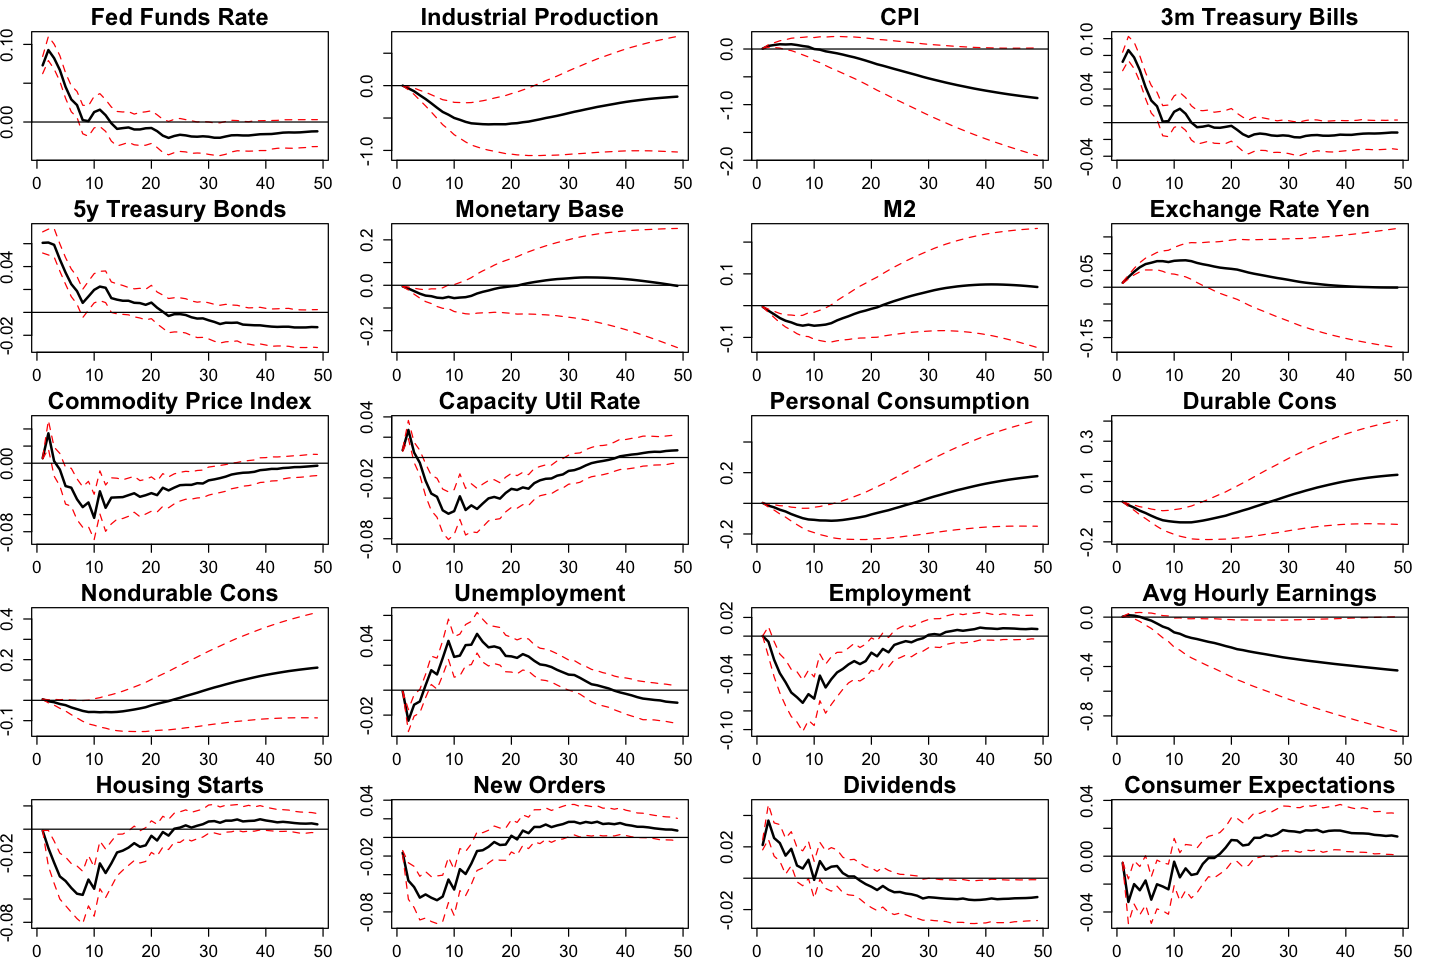

In [13]:
# Replicating Figure II in BBE (2005) - 3 Factors and Y = FYFF
# Change plot size to 15 x 10
options(repr.plot.width=12, repr.plot.height=8)

par(mfrow=c(5,4), 
   mar = c(2, 2, 2, 2))

for(i in variables){
    index = which(variables == i)
    if(transf_code[index] == 5){
        plot(cumsum(IRF[,i]), type ='l',lwd=2, main = variable_names[index],
             ylab= "", xlab="Steps", ylim=range(cumsum(Lower[,i]),cumsum(Upper[,i])),
             cex.main=1.8, cex.axis=1.3)
        lines(cumsum(Upper[,i]), lty=2, col="red")
        lines(cumsum(Lower[,i]), lty=2, col="red")
        abline(h=0)
    }
    else{
        plot(IRF[,i], type ='l',lwd=2, main = variable_names[index],
             ylab= "", xlab="Steps", ylim=range((Lower[,i]),(Upper[,i])),
             cex.main=1.8, cex.axis=1.3)
        lines((Upper[,i]), lty=2, col="red")
        lines((Lower[,i]), lty=2, col="red")
        abline(h=0)  
    }
}

### How much of the variation is captured by the Factors and FYFF?

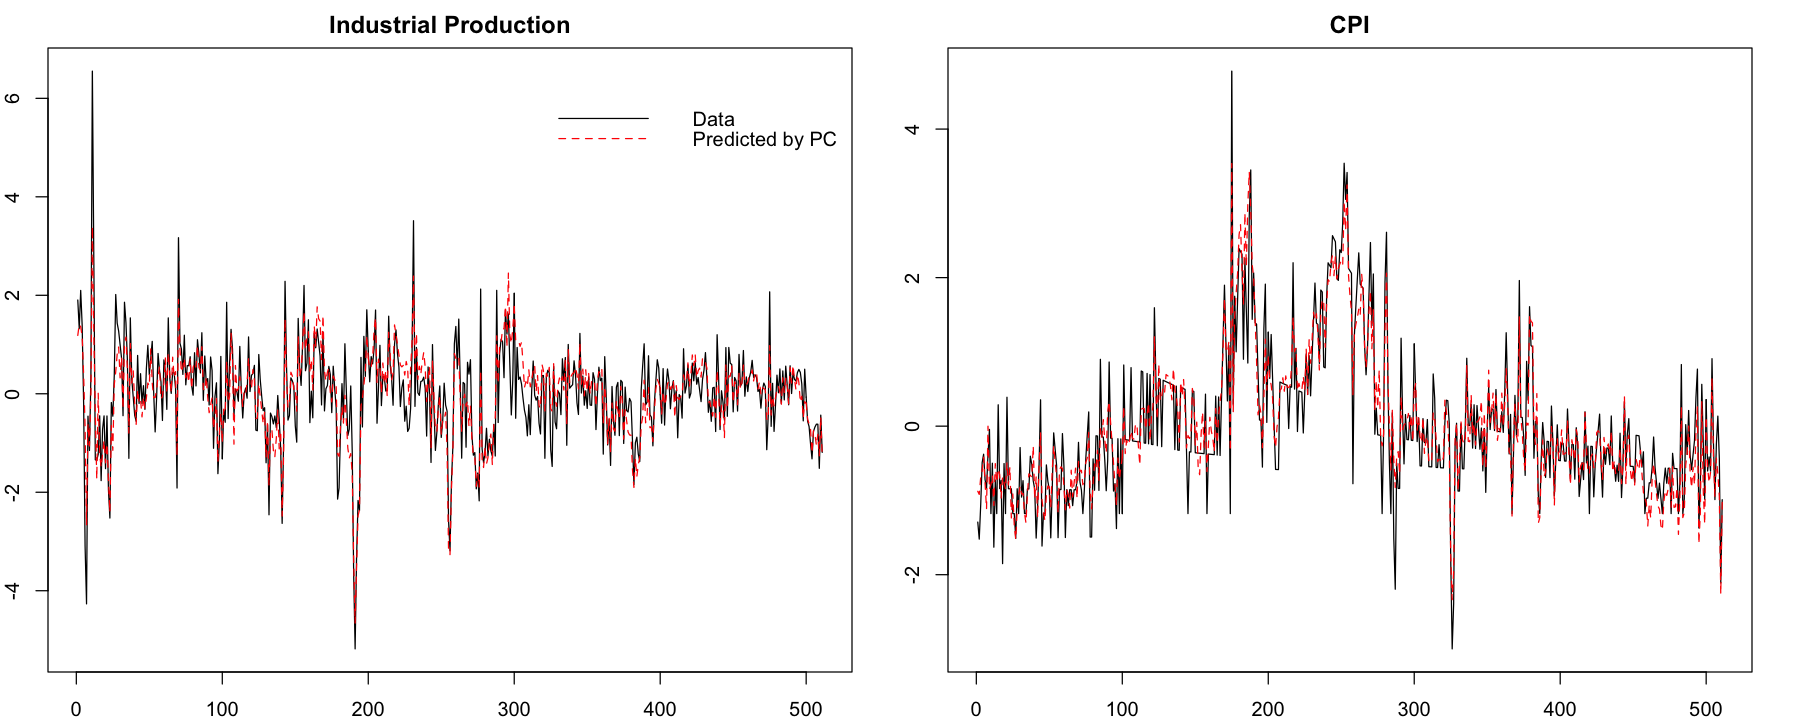

In [14]:
options(repr.plot.width=12, repr.plot.height=6)

par(mfrow=c(1,2), 
   mar = c(2, 2, 2, 2))

plot(data_s[, variables[2]], type = "l", ylab = "", main = "Industrial Production")
lines(fitted(reg_loadings)[,variables[2]], lty=2, col="red")
legend(300,6, legend=c("Data", "Predicted by PC"), lty = 1:2, col = c("black", "red"), 
      box.lty=0)
plot(data_s[, variables[3]], type = "l", ylab = "", main = "CPI")
lines(fitted(reg_loadings)[,variables[3]], lty=2, col="red")

## Step 5: FEVD

One step-ahead Variance Decomposition of $X_t$:

$$
E_t[X_{t+1} - X_t] =  \Lambda^f E_t[F_{t+1} - F_t]  +  \Lambda^y E_t [Y_{t+1} - Y_t] +  e_{t+1}
$$

$$
F_t = \mu_f + L^1 \varepsilon_t + A_1 L^1 \varepsilon_t + ... 
$$

$$
Y_t = \mu_y + L^2 \varepsilon_t + A_1 L^2 \varepsilon_t + ... 
$$

where $L = \begin{bmatrix} L^1 \\ L^2 \end{bmatrix}$ is the lower triangle matrix from the Cholesky decomposition. Let $\Lambda = \begin{bmatrix} \Lambda^f \\ \Lambda^y \end{bmatrix}$, we have that:

$$
E_t[X_{t+1} - X_t] =  \Lambda L E_t[ \varepsilon_{t+1}]  +  E_t[e_{t+1}]
$$

$$
E_t[X_{t+1} - X_t] =  \Psi(0) E_t[ \varepsilon_{t+1}] +  E_t[e_{t+1}]
$$

$$
var(E_t[X_{t+1} - X_t]) =  \Psi(0) \Sigma_\varepsilon (\Psi(0)))'  +  \sigma^2_e
$$

where $\Sigma_\varepsilon = I $ because of the Cholesky decomposition, and $\Psi(0)$ is a 1x4 vector with the contemporaneous response of X_t to all structural shocks. Hence, the total variance of each observable variable $X_t$ is just the sum of the squared impulse response functions plus the variance of the measurement error.

At step-ahead $j$:

$$
var(E_t[X_{t+j} - X_t]) =  \sum_{i=0}^j \Psi(i)(\Psi(i)))'  +  \sigma^2_e
$$

The variance of $E_t[X_{t+j} - X_t]$ that comes from the monetary policy shock alone is given by:

$$
var(E_t[X_{t+j} - X_t|\varepsilon_F, e_t]) =  \sum_{i=0}^j \Psi_{MP}(i)(\Psi(i)_{MP}))' 
$$

where $\Psi(i)_{MP} = \Psi(i)(1,4)$, i.e. the impulse response to monetary policy shock. Hence, the contribution of monetary policy shock to the $j$ step-ahead forecast error variance is given by:

$$
{\text{FEVD}}(j)_{MP}^X = \frac{var(E_t[X_{t+j} - X_t|\varepsilon_F, e_t])}{var(E_t[X_{t+j} - X_t])}
$$

In [15]:
# Get the VAR point estimates
hor = 60
var = VAR(data_var, p = 13)
irf_point = irf(var, n.ahead = hor, boot = FALSE)

In [16]:
# Get IRFs for all of X we are interested in, Dimensions: (hor, key_nvars)
# Find loadings
results = summary(reg_loadings) # the warning comes because of FYFF

key_nvars = length(variables)
irf_X_pc1 = array(c(0,0), dim=c(hor+1, key_nvars))
irf_X_pc2 = array(c(0,0), dim=c(hor+1, key_nvars))
irf_X_pc3 = array(c(0,0), dim=c(hor+1, key_nvars))
irf_X_fyff = array(c(0,0), dim=c(hor+1, key_nvars))

for(i in 1:key_nvars){
    irf_X_pc1[,i] = irf_point$irf$PC1 %*% matrix(loadings[2:5, variables[i]])
    irf_X_pc2[,i] = irf_point$irf$PC2 %*% matrix(loadings[2:5, variables[i]])
    irf_X_pc3[,i] = irf_point$irf$PC3 %*% matrix(loadings[2:5, variables[i]])
    irf_X_fyff[,i] = (irf_point$irf$FYFF) %*% matrix(loadings[2:5, variables[i]])
    }

Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”


In [17]:
# Get the IRFs squared and accumulate them
psi2_pc1 = array(0, dim = key_nvars)
psi2_pc2 = array(0, dim = key_nvars)
psi2_pc3 = array(0, dim = key_nvars)
psi2_fyff = array(0, dim = key_nvars)

for(i in 1:key_nvars){
    for(j in 1:hor){
        psi2_pc1[i] = psi2_pc1[i] + irf_X_pc1[j,i]^2
        psi2_pc2[i] = psi2_pc2[i] + irf_X_pc2[j,i]^2
        psi2_pc3[i] = psi2_pc3[i] + irf_X_pc3[j,i]^2
        psi2_fyff[i] = psi2_fyff[i] + irf_X_fyff[j,i]^2    
    }
}

In [18]:
var_total= array(0, dim = key_nvars)
var_fac= array(0, dim = key_nvars)
var_e= array(0, dim = key_nvars)

for(i in 1:key_nvars){
    var_fac[i] = psi2_pc1[i] + psi2_pc2[i] + psi2_pc3[i] + psi2_fyff[i]
    var_total[i] = psi2_pc1[i] + psi2_pc2[i] + psi2_pc3[i] + psi2_fyff[i] + results[[variables[i]]]$sigma
    var_e[i] = results[[variables[i]]]$sigma
}

In [19]:
table = data.frame("PC1" = round((psi2_pc1),3), "PC2" = round((psi2_pc2),3), "PC3" = round((psi2_pc3),3), "FYFF" = round((psi2_fyff),3),
                  "Factor_Y_total" = round(var_fac,3) ,"e" = round((var_e),3), "Total" = round(var_total,3))
row.names(table) = variable_names
table

,PC1,PC2,PC3,FYFF,Factor_Y_total,e,Total
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fed Funds Rate,0.497,0.279,0.059,0.150,0.985,0.000,0.985
Industrial Production,0.550,0.037,0.054,0.147,0.787,0.505,1.293
CPI,0.155,0.701,0.019,0.117,0.991,0.372,1.363
3m Treasury Bills,0.456,0.281,0.048,0.130,0.914,0.159,1.073
5y Treasury Bonds,0.299,0.309,0.015,0.087,0.710,0.260,0.970
Monetary Base,0.017,0.056,0.010,0.005,0.087,0.950,1.037
M2,0.017,0.014,0.007,0.005,0.042,0.977,1.020
Exchange Rate Yen,0.016,0.003,0.005,0.005,0.028,0.992,1.020
Commodity Price Index,0.250,0.272,0.032,0.154,0.709,0.602,1.311


In [20]:
# Replicating Table I in BBE (2005) - 3 Factors and Y = FYFF
r2 = array(0, dim = key_nvars)
for(i in 1:key_nvars){
    r2[i] = results[[variables[i]]]$r.squared
    }

In [21]:
table2 = data.frame("Variables" = variable_names, "Contribution" = round((psi2_fyff/var_total),3), "R-squared" = round(r2,3))
table2

Variables,Contribution,R.squared
<fct>,<dbl>,<dbl>
Fed Funds Rate,0.152,1.000
Industrial Production,0.114,0.746
CPI,0.086,0.863
3m Treasury Bills,0.121,0.975
5y Treasury Bonds,0.090,0.933
Monetary Base,0.005,0.105
M2,0.005,0.052
Exchange Rate Yen,0.005,0.024
Commodity Price Index,0.118,0.640
